In [1]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import matplotlib.pyplot as plt

### Import flight data  
All flights from Moscow between May 24 - June 24, 2023 (pulled from Icarus)

In [2]:
df = pd.read_csv("/Users/karinashedrofsky/LEDE_2023/flights-project/icarus_flights.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9026 entries, 0 to 9025
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   icao                 9026 non-null   object
 1   call_sign            8566 non-null   object
 2   start_time           9026 non-null   object
 3   end_time             9026 non-null   object
 4   origin_area          9026 non-null   object
 5   origin_country       9026 non-null   object
 6   destination_area     8433 non-null   object
 7   destination_country  8429 non-null   object
 8   aircraft_model       1950 non-null   object
 9   aircraft_model_code  1950 non-null   object
dtypes: object(10)
memory usage: 705.3+ KB


# Check out the data

### Show all origin locations
The "Moscow" search on Icarus includes flights from cities near Moscow

In [3]:
origin_counts = df.groupby('origin_area').size().reset_index(name='count')
origin_counts.sort_values(by='count', ascending=False).reset_index(drop=True)

,origin_area,count
0,Moskovsskaya,5347
1,Moskva,2904
2,Vladimir,260
3,Kaluga,247
4,Tula,65
5,Yaroslavl',60
6,Ryazan',53
7,Tver',45
8,Ivanovo,41
9,Nizhegorod,3


#### Group together Moskovsskaya and Moskva to make "Moscow"


In [4]:
replacements = {
    'Moskovsskaya': 'Moscow',
    'Moskva': 'Moscow'
}

df['origin_area'] = df['origin_area'].replace(replacements)

### Show all destination countries

In [5]:
dest_country_counts = df.groupby('destination_country').size().reset_index(name='count')
dest_country_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
dest_country_counts

,destination_country,count
0,Al Muḩarraq,9
1,Algeria,1
2,Armenia,173
3,Azerbaijan,102
4,Bangladesh,1
5,Belarus,136
6,Belgium,3
7,Cuba,3
8,Democratic Republic of the Congo,1
9,Egypt,73


### All destination 'areas'

In [6]:
dest_area_counts = df.groupby('destination_area').size().reset_index(name='count')
dest_area_counts.sort_values(by='count', ascending=False).reset_index(drop=True)
dest_area_counts.head()

,destination_area,count
0,Abkhazia,17
1,Abu Dhabi,22
2,Abşeron,1
3,Ad Dakhliyah,2
4,Ad Daqahliyah,2


### Clean the destination names in the df

In [7]:
replacements = {
    'Moskovsskaya': 'Moscow',
    'Moskva': 'Moscow',
    'City of St. Petersburg': 'St. Petersburg'
}

df.loc[:, 'destination_area'] = df['destination_area'].replace(replacements)

In [8]:
replacements = {
    'Al Muḩarraq': 'Bahrain'
}

df.loc[:,'destination_country'] = df['destination_country'].replace(replacements)

### Make new df that combines area and country for map viz

In [9]:
df.loc[:,'area_country'] = df['destination_area'] + ', ' + df['destination_country'].copy()
df.head()

,icao,call_sign,start_time,end_time,origin_area,origin_country,destination_area,destination_country,aircraft_model,aircraft_model_code,area_country
0,4c01e7,NaN,2023-06-24T23:47:28.488Z,2023-06-24T23:59:44.397Z,Moscow,Russia,Moscow,Russia,Airbus A320-231,L2J,"Moscow, Russia"
1,155c63,RWZ017,2023-06-24T23:40:53.347Z,2023-06-24T23:59:44.297Z,Moscow,Russia,Moscow,Russia,NaN,NaN,"Moscow, Russia"
2,151d57,UTA363,2023-06-24T22:59:28.172Z,2023-06-24T23:59:39.161Z,Moscow,Russia,Tatarstan,Russia,NaN,NaN,"Tatarstan, Russia"
3,152071,SVR8973,2023-06-24T22:47:12.297Z,2023-06-24T23:56:49.892Z,Tver',Russia,Saratov,Russia,NaN,NaN,"Saratov, Russia"
4,151ff2,AFL1894,2023-06-24T22:27:47.092Z,2023-06-24T23:34:56.19Z,Vladimir,Russia,Tatarstan,Russia,NaN,NaN,"Tatarstan, Russia"


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9026 entries, 0 to 9025
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   icao                 9026 non-null   object
 1   call_sign            8566 non-null   object
 2   start_time           9026 non-null   object
 3   end_time             9026 non-null   object
 4   origin_area          9026 non-null   object
 5   origin_country       9026 non-null   object
 6   destination_area     8433 non-null   object
 7   destination_country  8429 non-null   object
 8   aircraft_model       1950 non-null   object
 9   aircraft_model_code  1950 non-null   object
 10  area_country         8429 non-null   object
dtypes: object(11)
memory usage: 775.8+ KB


# Scraping from Radarbox for more plane details

The first attempt at scraping from Radarbox resulted in a number of blank pages, meaning Radarbox doesn't have webpages or data on some of the ICAOs. I found that, in some cases, it's because some ICAOs are missing a '0' at the front. To maximize the number of pages pulled from Radarbox, I put a '0' in front of every ICAO with fewer than 6 characters. 

#### Add a 0 to the front of every icao < 6 characters

In [11]:
df.loc[df['icao'].str.len() < 6, 'icao'] = '0' + df['icao']

### Pull all unique ICAOs to use to scrape Radarbox profiles for plane tail numbers and type  
Radarbox urls are formatted ``https://www.radarbox.com/data/mode-s/{ICAO}``

In [12]:
unique_icaos = df['icao'].unique().tolist()
len(unique_icaos)

1063

### Save the html for each available Radarbox page, which contains info on the planes tail number and make/model

In [13]:
directory = "/Users/karinashedrofsky/LEDE_2023/flights-project/radarbox-htmls"
base_url = "https://www.radarbox.com/data/mode-s/"

In [26]:
for icao in unique_icaos:
    try:
        # Construct the URL for each ICAO code by appending it to the base URL
        url = base_url + icao

        response = requests.get(
            url,
            headers={"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.5112.79 Safari/537.36"}
        )

        # Save HTML content to a separate file in the 'radarbox-htmls' directory
        file_name = icao + ".html"
        file_path = os.path.join(directory, file_name)
        
        if os.path.exists(file_path): #skip scraping webpages for icaos that have already been scraped
            continue

        with open(file_path, 'w', encoding='utf-8') as file:
            file.write(response.text)

        print("HTML content saved to:", file_path)

        # Add a pause of 2 seconds between each iteration
        time.sleep(2)

    except Exception as e:
        print(f"Error occurred for ICAO code: {icao}")
        print(f"Error message: {str(e)}")

### Check for all htmls that didn't scrape properly (based on file size) and delete them from the directory  
All htmls without detailed plane information on Radarbox are < 252,000 bytes  
_output is currently blank because I re-ran the code_

In [23]:
failed_icaos = []

# Get a list of all files in the directory
file_list = os.listdir(directory)


for file_name in file_list:
    file_path = os.path.join(directory, file_name)
    
    
    # Check if the file is smaller than 252000 bytes
    if os.path.getsize(directory + '/' + file_name) < 252000:
        # Make a list of all icaos that don't have populated Radarbox page (append file name without the ".html" extension)
        file_name_without_extension = file_name[:-5] 
        failed_icaos.append(file_name_without_extension)

        try:
            # Delete the file from directory
            os.remove(file_path)
            print(f"Deleted file: {file_path}")
        except OSError as e:
            print(f"Error occurred while deleting {file_path}: {str(e)}")
            

print(failed_icaos)

[]


### Scrape tail number and plane type from Radarbox page for each ICAO

In [14]:
data_list = []

# Loop through each HTML file in the radarbox_htmls directory
for filename in os.listdir(directory):
    if filename.endswith(".html"):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            html = file.read()

        soup = BeautifulSoup(html)

        # Get icao from the filename (without the ".html" extension)
        icao = filename.replace(".html", "")

        # Extract tail number from the HTML content
        try:
            tail = soup.select("#secondary")[0].text
        except IndexError:
            tail = ""
        # Extract the plane model from the HTML content
        try:
            plane = soup.select("#aircraft-info .full-width #value")[0].text
        except IndexError:
            plane = ""

        # Append the extracted data to the data_list
        data_list.append([icao, tail, plane])

# Create a DataFrame from the data_list with appropriate column names
plane_df = pd.DataFrame(data_list, columns=["icao", "tail", "plane"])

In [15]:
plane_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   icao    1052 non-null   object
 1   tail    1052 non-null   object
 2   plane   1052 non-null   object
dtypes: object(3)
memory usage: 24.8+ KB


#### Check which planes had a Radarbox page but still missing tail and plane type

In [16]:
blank = plane_df[plane_df['tail'] == '']
blank

,icao,tail,plane
193,1418d8,,-
229,14fa0a,,-
304,466b38,,-
312,152c2e,,-
418,142586,,-
436,4b850c,,-
507,140ac5,,-
508,1506a6,,-
514,032091,,-
577,1506aa,,-


### Read in csv of ICAO, tail and plane type for all planes identified manually  
_Since there were only 22, I manually checked all ICAOs without info in Radarbox and created a separate csv_  
The link to the data sources can be found in the csv file in the directory

In [17]:
manual_df = pd.read_csv("/Users/karinashedrofsky/LEDE_2023/flights-project/manual-plane-data.csv")
manual_df.drop('link', axis=1, inplace=True)
manual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   icao    22 non-null     object
 1   tail    17 non-null     object
 2   plane   17 non-null     object
dtypes: object(3)
memory usage: 656.0+ bytes


#### Make new df that combines scraped plane info with manually identified plane info

In [18]:
# Create a copy of plane_df to make a new DataFrame for the updates
updated_plane_df = plane_df.copy()

# Set 'icao' as the index for both DataFrames
updated_plane_df.set_index('icao', inplace=True)
manual_df.set_index('icao', inplace=True)

# Update the values in updated_plane_df with the values from manual_df where there's an icao match
updated_plane_df.update(manual_df)

# Reset the index to bring 'icao' back as a regular column
updated_plane_df.reset_index(inplace=True)

In [19]:
updated_plane_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1052 entries, 0 to 1051
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   icao    1052 non-null   object
 1   tail    1052 non-null   object
 2   plane   1052 non-null   object
dtypes: object(3)
memory usage: 24.8+ KB


#### List of remaining ICAOs that couldn't be identified manually or by scraping Radarbox 

In [20]:
updated_plane_df[updated_plane_df["tail"] == '']

,icao,tail,plane
304,466b38,,-
514,032091,,-
682,600be9,,-
718,ea000f,,-
775,26002b,,-


## Use tail number to analyze where each plane was registered  
Usually the beginning of a tail number indicates the registration country

#### Make new column for beginning characters of tail number

In [21]:
# Check if the "tail" column contains a hyphen
has_hyphen = updated_plane_df['tail'].str.contains('-')

# Extract the characters before the hyphen 
extracted_tail = updated_plane_df['tail'].str.extract(r'^(.*?)(?:-|$)')

# For rows without hyphen, extract the first two letters that come *before numbers* in the "tail" column
extracted_first_two_letters = updated_plane_df.loc[~has_hyphen, 'tail'].str.extract(r'^([A-Za-z]{2})\d{2}')

# Combine the extracted values and store them in a new "tail_prefix" column
updated_plane_df['tail_prefix'] = extracted_tail.where(has_hyphen, extracted_first_two_letters)

# Set the values in the "tail_prefix" column to empty strings for rows that don't have hyphen or 2 letters followed by numbers
updated_plane_df.loc[~has_hyphen & updated_plane_df['tail_prefix'].isna(), 'tail_prefix'] = ''

#### Print all planes where registration country can't be determined automatically (to be checked manually)

In [22]:
outlier_tails = updated_plane_df[updated_plane_df['tail_prefix'] == '']
outlier_tails

,icao,tail,plane,tail_prefix
86,60003c,701,Airbus A319-132,
176,155c40,89152,Sukhoi Superjet 100-95B,
304,466b38,,-,
514,032091,,-,
580,053977,VARIOUS,Several Different Aircraft,
682,600be9,,-,
718,ea000f,,-,
775,26002b,,-,
837,1f3395,78741,Ilyushin Il-78M-90A,


## Scrape the Wikipedia page that defines which country each registration prefix belongs to

In [23]:
prefix_html = requests.get("https://en.wikipedia.org/wiki/List_of_aircraft_registration_prefixes").text
prefix_soup = BeautifulSoup(prefix_html)

In [24]:
#select the right table on the page
table = prefix_soup.select("table")[1]
table.text[:100]

'\n\nCountry or region\n\nRegistration prefix\n\nPresentation and notes\n\n\nAfghanistan\n\nYA[1]\n\nYA-AAA to YA-'

In [25]:
#select the first row from the table
header = table.select("tr")[0]
header

<tr>
<th scope="col">Country or region
</th>
<th scope="col">Registration prefix
</th>
<th class="unsortable" scope="col">Presentation and notes
</th></tr>

In [26]:
#extract the column names from the header
prefix_header = [ head.text.strip() for head in header.select("th") ]
prefix_header

['Country or region', 'Registration prefix', 'Presentation and notes']

In [27]:
#select all non-header rows from the table
row_els = table.select("tbody tr")[1:] #skip the first row, which is the header
len(row_els)

240

In [28]:
#extract the text from each row into a python list

prefix_entries = [
    [cell.text.strip() for cell in row.select("td")]
    for row in row_els
]

prefix_entries[0]

['Afghanistan', 'YA[1]', 'YA-AAA to YA-ZZZ.']

In [29]:
#turn the extracted data into a dataframe
prefix_df = pd.DataFrame(prefix_entries, columns=prefix_header)
prefix_df.head()

,Country or region,Registration prefix,Presentation and notes
0,Afghanistan,YA[1],YA-AAA to YA-ZZZ.
1,Albania,ZA[2],ZA-AAA to ZA-ZZZ.
2,Algeria,7T[3],7T-VAA to 7T-VZZ Civilian.\n7T-WAA to 7T-WZZ M...
3,Andorra,C3[2],C3-AAA to C3-ZZZ
4,Angola,D2[3],D2-AAA to D2-ZZZ. Colonial allocation CR-L.


In [30]:
#drop the brackets and number within each bracket from the 'Registration prefix' column
prefix_df['Registration prefix'] = prefix_df['Registration prefix'].str.replace(r'\s*\[.*?\]$', '', regex=True)

In [31]:
prefix_df.head()

,Country or region,Registration prefix,Presentation and notes
0,Afghanistan,YA,YA-AAA to YA-ZZZ.
1,Albania,ZA,ZA-AAA to ZA-ZZZ.
2,Algeria,7T,7T-VAA to 7T-VZZ Civilian.\n7T-WAA to 7T-WZZ M...
3,Andorra,C3,C3-AAA to C3-ZZZ
4,Angola,D2,D2-AAA to D2-ZZZ. Colonial allocation CR-L.


#### Make new dataframe that specifies the country associated with each registration prefix in the flight data 

In [32]:
reg_country_df = pd.merge(updated_plane_df, prefix_df, left_on='tail_prefix', right_on='Registration prefix', how='inner')

In [33]:
#Drop the extra columns after the merge
reg_country_df = reg_country_df.drop(columns=["Registration prefix", "Presentation and notes"])
#Make sure the country listed for the blank tail_prefix is also blank
reg_country_df.loc[reg_country_df['tail_prefix'] == '', 'Country or region'] = ''
reg_country_df

,icao,tail,plane,tail_prefix,Country or region
0,151d9c,RA-73116,Boeing 737-8LJ,RA,Russia
1,15206f,RA-73839,Airbus A321-251NX,RA,Russia
2,151d77,RA-73079,Boeing 767-3Y0ER,RA,Russia
3,14f110,RA-61712,Antonov An-148-100EA,RA,Russia
4,151e32,RA-73266,Boeing 737-83N,RA,Russia
...,...,...,...,...,...
1078,51408c,4L-GTI,Boeing 737-7CT,4L,Georgia
1079,09a055,C5-SUV,Embraer ERJ 135BJ Legacy 650,C5,Gambia
1080,504e64,ER-00006,Airbus A320-232,ER,Moldova
1081,515313,EY-787,Boeing 737-8GJ,EY,Tajikistan


#### .... B- is being attributed to China and Taiwan   
According to the Wikipedia page, China is B- followed by 4 numbers and Taiwan is B- followed by 5 numbers  

In [34]:
#Check all tail numbers that start with B
updated_plane_df[updated_plane_df['tail_prefix'] == 'B']

,icao,tail,plane,tail_prefix
21,78122f,B-8862,Airbus A330-343E,B
44,78076e,B-2088,Boeing 777-39LER,B
56,781094,B-8678,Airbus A330-343E,B
73,78139f,B-1096,Airbus A330-343E,B
74,7808cb,B-2033,Boeing 777-39LER,B
90,781364,B-1065,Airbus A330-343E,B
91,7816bd,B-308P,Airbus A330-243F,B
149,7810fb,B-8959,Airbus A330-243,B
160,780e2e,B-8015,Airbus A330-343,B
169,7808cc,B-2035,Boeing 777-39LER,B


In [35]:
#Check how many tails that start with B- are followed by 4 characters
count_4_characters = updated_plane_df[updated_plane_df['tail'].str.match(r'^B-\w{4}$')].shape[0]
count_4_characters

40

In [36]:
#Check how many tails that start with B- are followed by 5 characters
count_5_characters = updated_plane_df[updated_plane_df['tail'].str.match(r'^B-\w{5}$')].shape[0]
count_5_characters

0

#### All in this case are followed by 4 characters, so all are registered in China, not Taiwan

In [37]:
#Drop row from reg_country_df where 'Country or region' = Taiwan
reg_country_df = reg_country_df[(reg_country_df['Country or region'] != 'Taiwan')]
reg_country_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 1082
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   icao               1043 non-null   object
 1   tail               1043 non-null   object
 2   plane              1043 non-null   object
 3   tail_prefix        1043 non-null   object
 4   Country or region  1043 non-null   object
dtypes: object(5)
memory usage: 48.9+ KB


In [38]:
registration_counts = reg_country_df.groupby('Country or region').size().reset_index(name='count').sort_values(by='count', ascending=False)

In [39]:
registration_counts

,Country or region,count
23,Russia,725
28,Turkey,71
30,United Arab Emirates,64
6,China,40
31,Uzbekistan,16
16,Kazakhstan,14
8,Egypt,13
5,Belarus,11
2,Armenia,10
0,,9


In [40]:
registration_counts.to_csv("reg_country_counts.csv", index=False)

# Use ChatGPT to analyze the plane type

In [41]:
#Make list of all unique plane make/models from flight data
unique_planes = []

unique_planes.extend(updated_plane_df['plane'].unique().tolist())

In [42]:
len(unique_planes)

224

In [46]:
updated_plane_df[updated_plane_df['plane'] == '-']

,icao,tail,plane,tail_prefix
304,466b38,,-,
514,032091,,-,
682,600be9,,-,
718,ea000f,,-,
775,26002b,,-,


In [47]:
from dotenv import load_dotenv 
load_dotenv()

API_KEY = os.getenv("PROJECT_API_KEY")

In [48]:
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(openai_api_key=API_KEY, model_name="gpt-3.5-turbo")

In [51]:
template = """
Categorize the following airplane model as typically being used as either a
private plane, commercial plane, military plane or helicopter. 
Respond with only the plane type: PRIVATE, COMMERCIAL, MILITARY, HELICOPTER. 
Then print the maximum number of passengers the plane model can hold, 
separated from the plane type with a comma. Don't print anything else after the number of passengers.
If you're unable to determine the type of plane, simply print UNKNOWN

Airplane model: Boeing 737
Response: COMMERCIAL, 132

Airplane model: {plane_model}
Response:"""

results = []  

for plane in unique_planes:
    prompt = template.format(plane_model=plane)
    response = llm.predict(prompt)
    results.append([plane, response])

# Create a DataFrame from the 'results' list
plane_type_df = pd.DataFrame(results, columns=['Plane', 'Info'])

In [54]:
plane_type_df.to_csv("gpt_results.csv", index=False)

In [56]:
len(plane_type_df)

224

In [57]:
plane_type_df[['type', 'max_passengers']] = plane_type_df['Info'].str.split(',', expand=True)


plane_type_df.drop(columns=['Info'], inplace=True)

In [58]:
plane_type_df

,Plane,type,max_passengers
0,Boeing 737-8LJ,COMMERCIAL,132
1,Boeing 737-958ER,COMMERCIAL,189
2,Airbus A321-251NX,COMMERCIAL,240
3,Boeing 767-3Y0ER,COMMERCIAL,375
4,Airbus A320-214,COMMERCIAL,150
...,...,...,...
219,Boeing 737-8S3,COMMERCIAL,189
220,Boeing 757-28A,COMMERCIAL,239
221,Gulfstream Aerospace G-IV-SP,PRIVATE,19
222,Airbus A330-223,COMMERCIAL,440


In [59]:
plane_type_counts = plane_type_df.groupby('type').size().reset_index(name='count')
plane_type_counts

,type,count
0,COMMERCIAL,146
1,HELICOPTER,8
2,MILITARY,13
3,PRIVATE,52
4,UNKNOWN,5


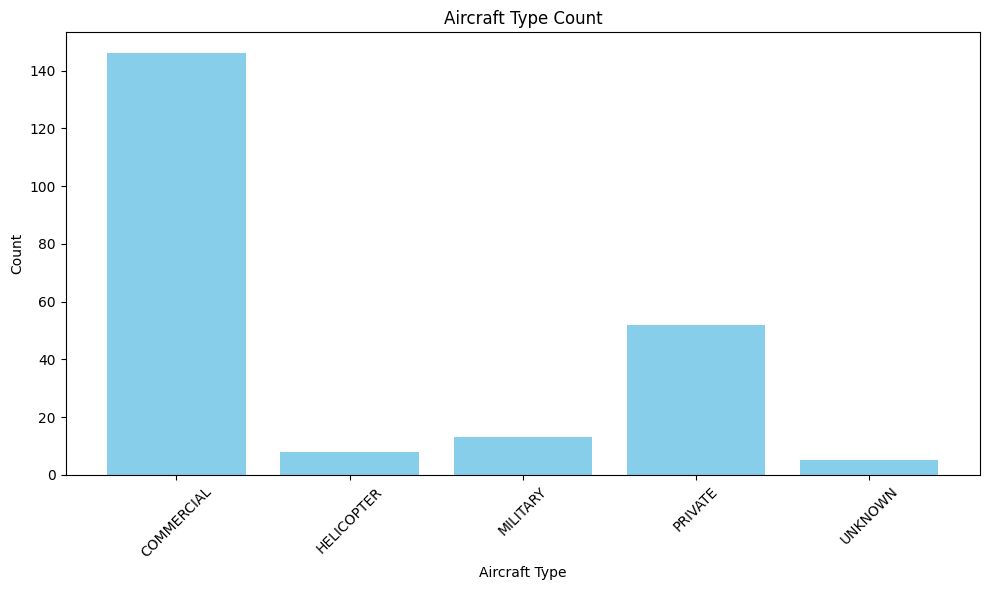

In [60]:
# Create bar chart
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.bar(plane_type_counts['type'], plane_type_counts['count'], color='skyblue')
plt.xlabel('Aircraft Type')
plt.ylabel('Count')
plt.title('Aircraft Type Count')
plt.xticks(rotation=45)
plt.tight_layout()

### Make df that combines plane type with registration and country

In [61]:
country_type_df = pd.merge(reg_country_df, plane_type_df, left_on='plane', right_on='Plane', how='inner')
country_type_df.drop('Plane', axis=1, inplace=True)
country_type_df.drop('tail_prefix', axis=1, inplace=True)

In [119]:
country_type_df.rename(columns={'plane': 'plane_model', 'Country or region': 'reg_country'}, inplace=True)

In [120]:
country_type_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   icao            1043 non-null   object
 1   tail            1043 non-null   object
 2   plane_model     1043 non-null   object
 3   reg_country     1043 non-null   object
 4   type            1043 non-null   object
 5   max_passengers  1030 non-null   object
dtypes: object(6)
memory usage: 49.0+ KB


### Export as html to turn into DataTables table for filtering and querying

In [121]:
country_type_table = country_type_df.to_html(index=False)

In [122]:
with open('country_type_table.html', 'w') as f:
    f.write(country_type_table)

### Check where the private planes are registered

In [63]:
private_planes_df = country_type_df[country_type_df['type'] == 'PRIVATE']
private_planes_df.groupby('Country or region').size()

Country or region
Algeria            1
Armenia            1
Azerbaijan         1
Belarus            1
China              1
Czech Republic     1
Gambia             1
Germany            1
Kazakhstan         6
Russia            83
Turkey             1
dtype: int64

#### Change country to get more info on plane registered in specified country

In [64]:
private_planes_df[private_planes_df['Country or region'] == 'Armenia']

,icao,tail,plane,Country or region,type,max_passengers
991,600009,EK-222,SOCATA TBM 940,Armenia,PRIVATE,6


###  Check where the military planes are registered

In [65]:
military_planes_df = country_type_df[country_type_df['type'] == 'MILITARY']
military_planes_df.groupby('Country or region').size()

Country or region
                 1
Azerbaijan       1
Russia          19
Syria            1
Turkmenistan     1
dtype: int64

#### Change country to get more info on military plane registered in specified country

In [66]:
military_planes_df[military_planes_df['Country or region'] == 'Syria']

,icao,tail,plane,Country or region,type,max_passengers
1037,778681,YK-ATA,Ilyushin Il-76T,Syria,MILITARY,UNKNOWN


## Create df that combines all flight info with identifying info

In [100]:
final_flights_df = pd.merge(df, country_type_df, on='icao', how='left')

In [101]:
final_flights_df.drop(columns=['aircraft_model', 'aircraft_model_code', 'area_country'], inplace=True)

In [102]:
final_flights_df.rename(columns={'Country or region': 'reg_country', 'type': 'plane_category'}, inplace=True)

In [103]:
final_flights_df.rename(columns={'plane': 'plane_model'}, inplace=True)

In [104]:
final_flights_df['max_passengers'] = final_flights_df['max_passengers'].str.upper()

In [105]:
final_flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9026 entries, 0 to 9025
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   icao                 9026 non-null   object
 1   call_sign            8566 non-null   object
 2   start_time           9026 non-null   object
 3   end_time             9026 non-null   object
 4   origin_area          9026 non-null   object
 5   origin_country       9026 non-null   object
 6   destination_area     8433 non-null   object
 7   destination_country  8429 non-null   object
 8   tail                 8944 non-null   object
 9   plane_model          8944 non-null   object
 10  reg_country          8944 non-null   object
 11  plane_category       8944 non-null   object
 12  max_passengers       8919 non-null   object
dtypes: object(13)
memory usage: 916.8+ KB


### Export as html to turn into DataTables table

In [123]:
full_flight_table = final_flights_df.to_html(index=False)

In [124]:
with open('full_flight_table.html', 'w') as f:
    f.write(full_flight_table)